In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay
from imblearn.combine import SMOTETomek
import os
%matplotlib inline

In [2]:
file_path = r"C:\Users\sb013698\Desktop\github\Hybrid UBEM Tool\Synthetic Data Generation\Datasets"
data = pd.read_csv(os.path.join(file_path, "simulation_results.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Scenario           2000 non-null   object 
 1   dhw_flow_rate      2000 non-null   float64
 2   equipment_density  2000 non-null   float64
 3   heating_set_point  2000 non-null   int64  
 4   infiltration       2000 non-null   float64
 5   lighting_density   2000 non-null   float64
 6   NG_MAPE            2000 non-null   float64
 7   NG_CV-RMSE         2000 non-null   float64
 8   Elec_MAPE          2000 non-null   float64
 9   Elec_CV-RMSE       2000 non-null   float64
 10  TOE_MAPE           2000 non-null   float64
 11  TOE_CV-RMSE        2000 non-null   float64
dtypes: float64(10), int64(1), object(1)
memory usage: 187.6+ KB


In [3]:
data.head()

,Scenario,dhw_flow_rate,equipment_density,heating_set_point,infiltration,lighting_density,NG_MAPE,NG_CV-RMSE,Elec_MAPE,Elec_CV-RMSE,TOE_MAPE,TOE_CV-RMSE
0,S1836,0.000111,8.75,21,0.3,5.0,0.238036,0.437481,0.639391,0.350574,0.104075,0.118024
1,S1637,0.000111,6.25,21,0.3,7.5,0.238078,0.437654,0.638762,0.350436,0.103916,0.118109
2,S1537,0.000111,5.00,21,0.3,7.5,0.220025,0.384299,0.495540,0.297652,0.103604,0.119809
3,S1736,0.000111,7.50,21,0.3,5.0,0.221008,0.388749,0.496185,0.297889,0.104059,0.120167
4,S1656,0.000111,6.25,22,0.2,5.0,0.152617,0.218336,0.362325,0.241727,0.095021,0.123257


# Preprocessing

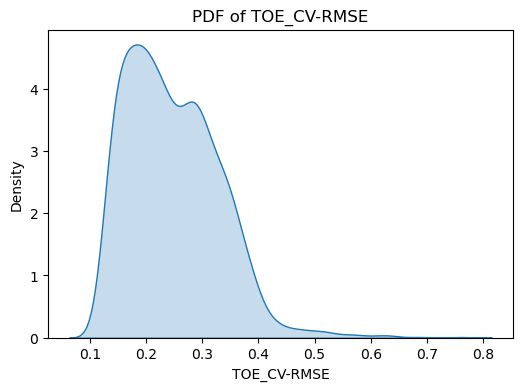

In [4]:
# Create a kernel density estimate plot (PDF) for the "TOE_CV-RMSE" column
plt.figure(figsize=(6, 4))
sns.kdeplot(data["TOE_CV-RMSE"], fill=True)
plt.xlabel("TOE_CV-RMSE")
plt.ylabel("Density")
plt.title("PDF of TOE_CV-RMSE")
plt.show()

In [5]:
new_df = data.copy()

# Define a random error rate for the decision boundary
decision_boundary = 0.15

# Label scenarios based on the CV-RMSE and the decision boundary
for i in range(new_df.shape[0]):
    
    if new_df.loc[i, "TOE_CV-RMSE"] <= decision_boundary:
        new_df.loc[i, "Label"] = 1
    else:
        new_df.loc[i, "Label"] = 0
        
new_df["Label"].value_counts()

Label
0.0    1798
1.0     202
Name: count, dtype: int64

In [6]:
# Calculate the interquartile range (IQR)
q1 = new_df["TOE_CV-RMSE"].quantile(0.25)
q3 = new_df["TOE_CV-RMSE"].quantile(0.75)
iqr = q3 - q1
print(f"Interquartile Range (IQR) for TOE_CV-RMSE: {iqr:.3f}")

upper_boundary = q3 + (1.5 * iqr)
print(f"Upper boundary for outliers: {upper_boundary:.3f}")

# Remove outliers based on the upper boundary
mydf = new_df[new_df["TOE_CV-RMSE"]<=upper_boundary]

# Print the updated value counts
mydf["Label"].value_counts()

Interquartile Range (IQR) for TOE_CV-RMSE: 0.121
Upper boundary for outliers: 0.483


Label
0.0    1774
1.0     202
Name: count, dtype: int64

In [7]:
# Remove redundant columns
redundant_cols = ['NG_MAPE', 'NG_CV-RMSE', 'Elec_MAPE', 'Elec_CV-RMSE', 'TOE_MAPE', 'TOE_CV-RMSE']
mydf = mydf.drop(columns=redundant_cols)
mydf.head()

,Scenario,dhw_flow_rate,equipment_density,heating_set_point,infiltration,lighting_density,Label
0,S1836,0.000111,8.75,21,0.3,5.0,1.0
1,S1637,0.000111,6.25,21,0.3,7.5,1.0
2,S1537,0.000111,5.00,21,0.3,7.5,1.0
3,S1736,0.000111,7.50,21,0.3,5.0,1.0
4,S1656,0.000111,6.25,22,0.2,5.0,1.0


In [8]:
mydf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1976 entries, 0 to 1975
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Scenario           1976 non-null   object 
 1   dhw_flow_rate      1976 non-null   float64
 2   equipment_density  1976 non-null   float64
 3   heating_set_point  1976 non-null   int64  
 4   infiltration       1976 non-null   float64
 5   lighting_density   1976 non-null   float64
 6   Label              1976 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 123.5+ KB


# Gaussian Naive Bayes Optimization Without Oversampling

              precision    recall  f1-score   support

         0.0       0.90      1.00      0.95      1774
         1.0       1.00      0.00      0.00       202

    accuracy                           0.90      1976
   macro avg       0.95      0.50      0.47      1976
weighted avg       0.91      0.90      0.85      1976





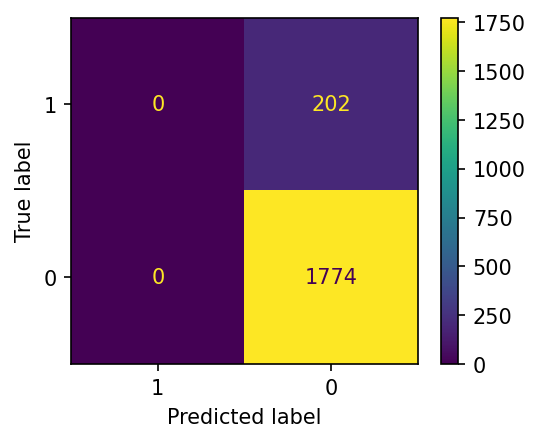

In [9]:
# Scale data
X = mydf.drop(columns=["Scenario", "Label"])
y = mydf["Label"]

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

bayes = GaussianNB()
bayes.fit(X_scaled, y)
preds = bayes.predict(X_scaled)

# Print classification report
print(classification_report(y, preds, zero_division=1))

print("\n" + "="*100 + "\n")

# Print a confusion matrix for the classification
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
labels = [1, 0]
cm = confusion_matrix(y, preds, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax)
plt.show()

In [10]:
# Get the estimated distribution parameters for Label-0 and Label-1
mean_list = scaler.inverse_transform(bayes.theta_)
var_list = scaler.inverse_transform(bayes.var_)

print("Estimated Means:", mean_list)
print("Estimated Variances:", var_list)

Estimated Means: [[7.01652762e-05 7.54509583e+00 2.15529876e+01 2.95264938e-01
  1.02691657e+01]
 [7.41960396e-05 7.26485149e+00 2.11881188e+01 3.61386139e-01
  8.13118812e+00]]
Estimated Variances: [[1.01094663e-04 9.28438224e+00 2.26921432e+01 4.46728368e-01
  1.36266272e+01]
 [9.91330468e-05 9.22016027e+00 2.19813231e+01 3.82066713e-01
  1.19484240e+01]]


In [11]:
# Expected mean and variances for each parameter: Label==0
param_list = X.columns
print("LABEL-1\n>>>>>")
for i in range(len(mean_list[0])):
    mean = mean_list[0][i]
    variance = var_list[0][i]

    # Create a normal distribution for the current parameter
    dist = norm(loc=mean, scale=np.sqrt(variance))

    # Calculate the expected value (mean) for the current parameter
    expected_value = dist.mean()
    
    if param_list[i] == "dhw_flow_rate":
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value}")
    else:
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value:.3f}")

LABEL-1
>>>>>
Expected value (mean) for Parameter dhw_flow_rate: 7.016527621195038e-05
Expected value (mean) for Parameter equipment_density: 7.545
Expected value (mean) for Parameter heating_set_point: 21.553
Expected value (mean) for Parameter infiltration: 0.295
Expected value (mean) for Parameter lighting_density: 10.269


In [12]:
# Expected mean and variances for each parameter: Label==1
param_list = X.columns
print("LABEL-1\n>>>>>")
for i in range(len(mean_list[1])):
    mean = mean_list[1][i]
    variance = var_list[1][i]

    # Create a normal distribution for the current parameter
    dist = norm(loc=mean, scale=np.sqrt(variance))

    # Calculate the expected value (mean) for the current parameter
    expected_value = dist.mean()
    
    if param_list[i] == "dhw_flow_rate":
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value}")
    else:
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value:.3f}")

LABEL-1
>>>>>
Expected value (mean) for Parameter dhw_flow_rate: 7.41960396039604e-05
Expected value (mean) for Parameter equipment_density: 7.265
Expected value (mean) for Parameter heating_set_point: 21.188
Expected value (mean) for Parameter infiltration: 0.361
Expected value (mean) for Parameter lighting_density: 8.131


In [13]:
# Select the optimal parameter values based on Label-1
optimal_values = {
    "dhw_flow_rate": mean_list[1][0].round(7),
    "equipment_density": mean_list[1][1].round(3),
    "heating_set_point": mean_list[1][2].round(3),
    "Infiltration": mean_list[1][3].round(3),
    "lighting_density": mean_list[1][4].round(3),
}

optimal_values

{'dhw_flow_rate': 7.42e-05,
 'equipment_density': 7.265,
 'heating_set_point': 21.188,
 'Infiltration': 0.361,
 'lighting_density': 8.131}

# Gaussian Naive Bayes Optimization With SMOTE Oversampling

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       356
         1.0       1.00      1.00      1.00        40

    accuracy                           1.00       396
   macro avg       1.00      1.00      1.00       396
weighted avg       1.00      1.00      1.00       396

ROC AUC Score: 0.8489466292134831
Average Precision Score: 0.36222722421756326




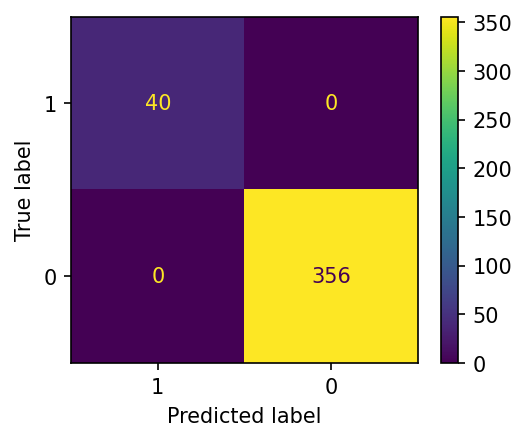

In [14]:
X = mydf.drop(columns=["Scenario", "Label"])
y = mydf["Label"]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Resample the data to address imbalance
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)

# Feature scaling
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)

# Hyperparameter tuning
param_grid = {'var_smoothing': np.logspace(0, -9, num=100)}
gnb = GaussianNB()
clf = GridSearchCV(gnb, param_grid, cv=5, scoring='roc_auc')
clf.fit(X_resampled_scaled, y_resampled)

# Best model
best_gnb = clf.best_estimator_

# Predict on the test data
y_pred = best_gnb.predict(X_test_scaled)
y_pred_proba = best_gnb.predict_proba(X_test_scaled)[:, 1]

# Classification report
print(classification_report(y_test, y_test))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
print("Average Precision Score:", average_precision_score(y_test, y_pred_proba))

print("\n" + "="*100 + "\n")

# Confusion Matrix
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
labels = [1, 0]
cm = confusion_matrix(y_test, y_test, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(ax=ax)
plt.show()

In [15]:
# Get the estimated distribution parameters for Label-0 and Label-1
mean_list = scaler.inverse_transform(best_gnb.theta_)
var_list = scaler.inverse_transform(best_gnb.var_)

print("Estimated Means:", mean_list)
print("Estimated Variances:", var_list)

Estimated Means: [[7.05172615e-05 7.57465404e+00 2.15579024e+01 2.93809177e-01
  1.02713037e+01]
 [7.63420653e-05 7.27887186e+00 2.10422433e+01 3.61412684e-01
  7.92527104e+00]]
Estimated Variances: [[1.05755343e-04 9.22868534e+00 2.26117681e+01 4.88813419e-01
  1.29873507e+01]
 [9.75954789e-05 9.03700297e+00 2.18316429e+01 4.02921163e-01
  1.09485885e+01]]


In [16]:
# Expected mean and variances for each parameter: Label==1
param_list = X.columns
print("LABEL-1\n>>>>>")
for i in range(len(mean_list[1])):
    mean = mean_list[1][i]
    variance = var_list[1][i]

    # Create a normal distribution for the current parameter
    dist = norm(loc=mean, scale=np.sqrt(variance))

    # Calculate the expected value (mean) for the current parameter
    expected_value = dist.mean()
    
    if param_list[i] == "dhw_flow_rate":
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value}")
    else:
        print(f"Expected value (mean) for Parameter {param_list[i]}: {expected_value:.3f}")

LABEL-1
>>>>>
Expected value (mean) for Parameter dhw_flow_rate: 7.63420652954938e-05
Expected value (mean) for Parameter equipment_density: 7.279
Expected value (mean) for Parameter heating_set_point: 21.042
Expected value (mean) for Parameter infiltration: 0.361
Expected value (mean) for Parameter lighting_density: 7.925


In [17]:
optimal_smote = {
    "dhw_flow_rate": mean_list[1][0].round(7),
    "equipment_density": mean_list[1][1].round(3),
    "heating_set_point": mean_list[1][2].round(3),
    "Infiltration": mean_list[1][3].round(3),
    "lighting_density": mean_list[1][4].round(3),
}

optimal_smote

{'dhw_flow_rate': 7.63e-05,
 'equipment_density': 7.279,
 'heating_set_point': 21.042,
 'Infiltration': 0.361,
 'lighting_density': 7.925}

# END